# Exploring the UTx000 Extension Beacon Data
(See the [GH repo](https://github.com/intelligent-environments-lab/utx000))

In [2]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# Sensitivity Analysis
There are quite a few assumptions that are baked into the ventilation rate calculation and it would be interesting to see how estimates change when we vary the assumptions between _reasonable_ limits. There are three main parameters in both the static and dynamic estimation methods that we should consider:
* $V$: volume of the bedroom
* $E$: person co2 emission rate
* $C_0$: background co2 concentration

## Package Import

In [3]:
import os
import sys
sys.path.append('../')

from src.visualization import visualize
from src.analysis import ventilation
from src.analysis import occupancy_detection

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import math
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from sklearn.neural_network import MLPClassifier

---

<a id="toc"></a>

# Table of Contents

1. [Data Notes](#data)
2. [Analysis Notes](#analysis)
    1. [Steady-State Estimation](#steady_state)
    2. [Dynamic Estimation](#dynamic)
    3. [Sensitivity Analysis](#sa)
4. [SA: Steady-State](#ss_sa)
5. [SA: Build-Up](#buildup_sa)
6. [SA: Decay](#decay_sa)

---

<a id="data"></a>

# Notes on Data Used
The necesary data are imported when insantiating a `calculate` object. 

---

<a id="analysis"></a>

# Notes on Analysis
We start with a short description on the estimation methods -- for more information on the individual parameters within each method, see the primary notebook [here](https://github.com/intelligent-environments-lab/utx000/blob/master/notebooks/4.1.4-hef-beacon-ventilation_estimation.ipynb).

<a id="steady_state"></a>

[Back to ToC](#toc)
## Ventilation based on constant CO2 concentration
We can estimate the ventilation rate of the participants' bedrooms based on a constant CO2 concentration:

$$
\lambda = \frac{E}{V \left(C - pC_0\right)}
$$

In our case we have to make quite a few assumptions:
- $E$: Emission rate of CO2 can be estimated for humans to be approximately $30 g/hr$. We can further refine this value by considering the height, weight, sex, and activity level of the participant - all information that we have access to. 
- $V$: Arguably the most difficult value to track down and the one that could affect the answer the most. We can assume a volume of each of the participants bedrooms, but there is the possiblility of refining this value by cross-referencing the participants' addresses with any known apartment complexes. From there, we can estimate the floor plan based on the number of roommates.
- $p$: Penetration factor of background CO2 from into the space - we can safely assume this to be 1.
- $C_0$: Background CO2 concentration. While 400 - 450 ppm is the typical assumption, using this value seems to result in very low ventilation rates.

<a id="dynamic"></a>

[Back to ToC](#toc)
## Ventilation Based on Dynamic Solution
We can estimate the ventilation rate of the participants' bedrooms using the dynamic solution to the CO2 mass balance:

$$
C_t = C_{t=0}e^{-\lambda t} + \left(pC_0 + \frac{E}{\lambda V}\right)\left(1 - e^{-\lambda t}\right)
$$

The benefit of this approach is that the exchange rate we get might be agnostic to the accuracy of the sensor assuming the sensor is precise (just off from the true value by a constant difference).

Many of the variables from the previous analysis show up here again which is nice since we already found those. 
- $C_t$: CO2 concentation at some time, $t$
- $C_{t=0}$: CO2 concentration at the beginning of the analysis period
- $E$: Emission rate of CO2 estimated from the Persily and Jonge (2016) paper which looks at the activity, sex, and BMR of the participant. 
- $V$: We opted for a more generic value rather than diving too deep.
- $\lambda$: air exchange rate
- $p$: Penetration factor of CO2 from outside into the indoor space - we can safely assume this to be 1.
- $C_0$: Background CO2 concentration. 

### Solution 1: Build-Up - Occupant initially enters the space
We can directly apply the above equation. If so, we have to undergo a similar process as with the constant CO2 method i.e. we need the emission rate and the volume of the space. 

### Solution 2: Decay - Occupant leaves the space after sleep event
If the participant leaves the bedroom, we don't have any emission sources. Therefore, our equation simplifies to:

$$
C_t = C_{t=0}e^{-\lambda t} + pC_0\left(1 - e^{-\lambda t}\right)
$$

<a id="sa"></a>

[Back to ToC](#toc)
## Sensitivity Analyses Used
We consider two types of sensitivity analyses in this notebook:
1. One-Way: A more "standard" approach to sensitivity analysis. We vary one parameter within a range of values while holding all others constant and analyze the effect on the output -- ventilation rate in this case.
2. Global: Now we consider the combined effect of parameters on the output. For this method, we consider Sobol Indices which is described in more detail [here](https://docs.lib.purdue.edu/cgi/viewcontent.cgi?article=3384&context=icec). 

[Back to Top](#sa)

---

---

<a id="param_range"></a>

[Back to ToC](#toc)
# Determining Parameter Ranges for SA
Not as straight-forward as one would think.

In [4]:
sa = ventilation.sensitivity_analysis(data_dir="../data")

In [5]:
def print_sa_param_steps(limit, use_steps=True, steps=[0,25,50,75,100],
                         percents=[-0.2,-0.1,0,0.1,0.2],for_latex=False,decimals=1):
    """
    Prints the key values for the given limit
    """
    if for_latex:
        ending = " & "
        final_ending = " \\\\"
    else:
        ending = " "
        final_ending = " "
    if use_steps:
        for step in steps:
            if step == 100:
                print(round(np.percentile(limit,step),decimals),end=final_ending)
            else:
                print(round(np.percentile(limit,step),decimals),end=ending)
    else:
        for p in percents:
            if p == 0.2:
                print(round(np.mean(limit) * (1+p),decimals),end=final_ending)
            else:
                print(round(np.mean(limit) * (1+p),decimals),end=ending)

## Volume
We need to determine reasonable values for the volume of an apartment and home bedroom.

### Apartment
The [minimum floor area](https://buildingcodetrainer.com/minimum-bedroom-size/) for a bedroom with a single occupant is 70 ft$^2$. We can use this number along with the fact that [ceiling heights](https://www.hunker.com/12591709/what-is-the-minimum-ceiling-height-according-to-the-international-building-code) must be a minimum of 7 ft to get an _absolute_ minimum volume of **490 ft$^3$**. This value is quite small and is unlikely given the demographics of our population so, in an effort to circumvent this issue, I use the mean of this value and the default volume to get **712 ft$^3$ as the minimum $V$**. 

The maximum will be whatever volume ensures that the default value of 1080 ft$^3$ is the center of the range, meaning **1449 ft$^3$ as the maximum $V$**. 

### House
The minimum bedroom size for a home is still the same by code, but we will increase one dimension by one foot to get **560 ft$^3$**. Using the same scheme as before, we get a **minium $V$ of 790 ft$^3$**.

In the same manner, the maximum volume is chosen to ensure that the default value is the midpoint. Therefore **1586 ft$^3$ is the maximum $V$**. 

<div class="alert-block alert alert-info">

**Apartment**: 712 - 1449
    
**Home**: 790 - 1586
<div>

## Increasing by Percent
Rather than do this odd practice as above, I can look at augment the base volume by a certain percentage.

In [26]:
h_us = 9
h_si = 9*0.3048
print(f"H (SI): {h_si}\tH (US): {h_us}")

H (SI): 2.7432000000000003	H (US): 9


### Apartment

SI

In [6]:
print_sa_param_steps(limit=[712,1448],use_steps=False)

864.0 972.0 1080.0 1188.0 1296.0 

In [21]:
l_apt, w_apt = 10, 12
print(f"L: {l_apt}\tW: {w_apt}\tA: {l_apt*w_apt}")

L: 10	W: 12	A: 120


Metric

In [7]:
print_sa_param_steps(limit=[712*0.0283168,1448*0.0283168],use_steps=False,for_latex=True)

24.5 & 27.5 & 30.6 & 33.6 & 36.7 \\

In [22]:
print(f"L: {l_apt*0.3048}\tW: {w_apt*0.3048}\tA: {l_apt*0.3048*w_apt*0.3048}")

L: 3.048	W: 3.6576000000000004	A: 11.148364800000001


### House

SI

In [8]:
print_sa_param_steps(limit=[790,1586],use_steps=False)

950.4 1069.2 1188.0 1306.8 1425.6 

In [23]:
l_home, w_home = 11, 12
print(f"L: {l_home}\tW: {w_home}\tA: {l_home*w_home}")

L: 11	W: 12	A: 132


Metric

In [9]:
print_sa_param_steps(limit=[790*0.0283168,1586*0.0283168],use_steps=False,for_latex=True)

26.9 & 30.3 & 33.6 & 37.0 & 40.4 \\

In [24]:
print(f"L: {l_home*0.3048}\tW: {w_home*0.3048}\tA: {l_home*0.3048*w_home*0.3048}")

L: 3.3528000000000002	W: 3.6576000000000004	A: 12.263201280000002


## Emission Rate
These limits are a bit trickier to estimate. The equation we are using for the emission rate, depends on a few variables. In the points below, we highlight the process we will use to determine limits on emission rate:

$$
V_{CO_2} = (BMR)(M)(T/P)(0.000179)
$$

* $T$: we can use the minimum and maximum temperature measured during the evenings for the range of possible temperatures. _$T$ is directly related to $E$_.
* $P$: while there are likely variations in pressure depending on the location, I think it is safe to assume a constant $P$ - **we will hold $P$ constant**. 
* $BMR$: BMR is dependent on the mass and sex of the individual. I think we are safe to use the minimum and maximum mass per sex to establish a limit on the mass for each sex and therefore BMR. _$BMR$ is directly related to $E$_.
* $M$: the activity level measured as METs should be held constant since we are safe to assume the participant is asleep - **we will hold $M$ constant**. 

### Temperature

In [10]:
min_t = np.nanmin(sa.beacon_nightly["temperature_c"])
max_t = np.nanmax(sa.beacon_nightly["temperature_c"])
print(f"Min:\t{min_t}\nMax:\t{max_t}")

Min:	15.38867915
Max:	33.13683188


### BMR

In [11]:
sa.info[["sex","mass","bmr"]].groupby(["sex"]).min()

,mass,bmr
sex,,
Female,47.173568,4.960761
Male,58.962424,6.610633


In [12]:
sa.info[["sex","mass","bmr"]].groupby(["sex"]).max()

,mass,bmr
sex,,
Female,80.720737,7.040686
Male,83.914520,8.182615


### Rate

In [13]:
esimates_with_info = sa.estimates_ss.merge(sa.info[["beacon","sex"]],on=["beiwe","beacon"],how="left")
mean_e = esimates_with_info.groupby(["sex"]).mean()["e"].values

In [14]:
min_e_f = sa.get_emission_rate(BMR=4.96,T=15.4+273.15)*3600
max_e_f = sa.get_emission_rate(BMR=7.04,T=33.1+273.15)*3600
min_e_m = sa.get_emission_rate(BMR=6.61,T=15.4+273.15)*3600
max_e_m = sa.get_emission_rate(BMR=8.18,T=33.1+273.15)*3600
print(f"Female:\n\tMin\t{min_e_f}\n\tMax\t{max_e_f}\nMale:\n\tMin\t{min_e_m}\n\tMax\t{max_e_m}")

Female:
	Min	8.547872326243901
	Max	12.876683707317072
Male:
	Min	11.391418563804875
	Max	14.961828512195119


<div class="alert-block alert alert-info">

**Female**: 0.0023744089795121946 - 0.0035768565853658532
    
**Male**: 0.0031642829343902427 - 0.004156063475609755
<div>

### By Percent

In [18]:
print_sa_param_steps([0.0023744089795121946*3600, 0.0035768565853658532*3600],
                     use_steps=False,decimals=1,for_latex=True)

8.6 & 9.6 & 10.7 & 11.8 & 12.9 \\

In [19]:
print_sa_param_steps([0.0031642829343902427*3600, 0.004156063475609755*3600],
                     use_steps=False,decimals=1,for_latex=True)

10.5 & 11.9 & 13.2 & 14.5 & 15.8 \\

## Background CO$_2$ Concentration
We have already seen how important this variable is in previous analysis. While, on the surface, this variable seems easy to manipulate, there are two configurations to consider:
1. **Vary CO$_2$ within constant limit**: Just like with $V$, we can determine a reasonable range of background CO$_2$ and apply it across _all_ participants. 
2. **Vary CO$_2$ within participant-based limit**: We can use percentiles of CO$_2$ measurements specific to each participant to determine a range of background concentrations.

The assumption of a constant rate similar across all participants is flawed, so we will only consider option 2 which simplifies the analysis a bit.

<div class="alert-block alert alert-info">
    
**Participant-Based**: 0th percentile (minimum) - 5th percentile
<div>

In [12]:
c0_limits = [0,4]
for p in [0,0.25,0.5,0.75,1]:
    print(np.percentile(c0_limits,p),end=" ")

0.0 0.01 0.02 0.03 0.04 

[Back to Top](#param_range)

---

<a id="ss_sa"></a>

[Back to ToC](#toc)
# SA: Steady-State
We start by considering the steady-state estimates first

### One-Way

In [13]:
ss_oneway = sa.run_one_way(method="ss",params=["e","v","c0"],steps=[0,0.25,0.5,0.75,1])

In [14]:
ss_oneway_summary = sa.compare_sa_to_base(ss_oneway,method="ss",steps=[0,0.25,0.75,1],plot=True)

NameError: name 'estimates_ss' is not defined

In [ ]:
sa.compare_sa_to_base_pt_v2(ss_oneway,estimates_ss,beacons_to_exclude=[1,25,44],save=False)

In [ ]:
sa.compare_sa_to_base_pt_v2(ss_oneway,estimates_ss,
                beacons_to_exclude=[beacon for beacon in res_sa_ss["beacon"].unique() if beacon not in [1,25,44]],
                save=False,annot="-high_rates")

In [ ]:
ss_oneway_summary

<div class="alert-block alert alert-info">

The volume seems to have the greatest effect on the ventilation estimates although we are taking ranges that are outside the dataset. Higher emission rates also tended to have a more pronounced effect on the ventilation rate. 
<div>

In [ ]:
for param in ["e"]:
    ss_oneway_param = ss_oneway[ss_oneway["parameter"] == param]
    ss_oneway_param_grouped = ss_oneway_param.groupby(["beacon","step"]).mean()
    ss_oneway_reshaped = ss_oneway_param_grouped["ach"].unstack(level=0)
    ss_avg = sa.estimates_ss.groupby("beacon").mean()
    for col in ss_oneway_reshaped.columns:
        ss_oneway_reshaped[col] = round((ss_oneway_reshaped[col]-ss_avg.loc[col,"ach"])/ss_avg.loc[col,"ach"],3)

In [ ]:
ss_oneway_reshaped.mean(axis=1).T

### Iterative Approach
Since we only have three parameters, we can also do a more comprehensive approach were for each parameter step, we vary the other two through all steps. This process helps to see if there are perhaps some interaction between parameters.

In [21]:
#ss_sa_comp = sa.traverse_param_range(verbose=True)
#ss_sa_comp_per = sa.traverse_param_percents(verbose=True)

No morning Beacon data available
Beacon 46
	Home
	Female
		C0: 0
		V: -20.0%
		E: -20.0%
	ACH: 0.43
		C0: 0
		V: -20.0%
		E: -10.0%
	ACH: 0.484
		C0: 0
		V: -20.0%
		E: 0%
	ACH: 0.538
		C0: 0
		V: -20.0%
		E: 10.0%
	ACH: 0.591
		C0: 0
		V: -20.0%
		E: 20.0%
	ACH: 0.645
		C0: 0
		V: -10.0%
		E: -20.0%
	ACH: 0.382
		C0: 0
		V: -10.0%
		E: -10.0%
	ACH: 0.43
		C0: 0
		V: -10.0%
		E: 0%
	ACH: 0.478
		C0: 0
		V: -10.0%
		E: 10.0%
	ACH: 0.526
		C0: 0
		V: -10.0%
		E: 20.0%
	ACH: 0.574
		C0: 0
		V: 0%
		E: -20.0%
	ACH: 0.344
		C0: 0
		V: 0%
		E: -10.0%
	ACH: 0.387
		C0: 0
		V: 0%
		E: 0%
	ACH: 0.43
		C0: 0
		V: 0%
		E: 10.0%
	ACH: 0.473
		C0: 0
		V: 0%
		E: 20.0%
	ACH: 0.516
		C0: 0
		V: 10.0%
		E: -20.0%
	ACH: 0.313
		C0: 0
		V: 10.0%
		E: -10.0%
	ACH: 0.352
		C0: 0
		V: 10.0%
		E: 0%
	ACH: 0.391
		C0: 0
		V: 10.0%
		E: 10.0%
	ACH: 0.43
		C0: 0
		V: 10.0%
		E: 20.0%
	ACH: 0.469
		C0: 0
		V: 20.0%
		E: -20.0%
	ACH: 0.287
		C0: 0
		V: 20.0%
		E: -10.0%
	ACH: 0.323
		C0: 0
		V: 20.0%
		E: 0%
	AC

	ACH: nan
		C0: 2
		V: 20.0%
		E: -10.0%
	ACH: nan
		C0: 2
		V: 20.0%
		E: 0%
	ACH: nan
		C0: 2
		V: 20.0%
		E: 10.0%
	ACH: nan
		C0: 2
		V: 20.0%
		E: 20.0%
	ACH: nan
		C0: 4
		V: -20.0%
		E: -20.0%
	ACH: nan
		C0: 4
		V: -20.0%
		E: -10.0%
	ACH: nan
		C0: 4
		V: -20.0%
		E: 0%
	ACH: nan
		C0: 4
		V: -20.0%
		E: 10.0%
	ACH: nan
		C0: 4
		V: -20.0%
		E: 20.0%
	ACH: nan
		C0: 4
		V: -10.0%
		E: -20.0%
	ACH: nan
		C0: 4
		V: -10.0%
		E: -10.0%
	ACH: nan
		C0: 4
		V: -10.0%
		E: 0%
	ACH: nan
		C0: 4
		V: -10.0%
		E: 10.0%
	ACH: nan
		C0: 4
		V: -10.0%
		E: 20.0%
	ACH: nan
		C0: 4
		V: 0%
		E: -20.0%
	ACH: nan
		C0: 4
		V: 0%
		E: -10.0%
	ACH: nan
		C0: 4
		V: 0%
		E: 0%
	ACH: nan
		C0: 4
		V: 0%
		E: 10.0%
	ACH: nan
		C0: 4
		V: 0%
		E: 20.0%
	ACH: nan
		C0: 4
		V: 10.0%
		E: -20.0%
	ACH: nan
		C0: 4
		V: 10.0%
		E: -10.0%
	ACH: nan
		C0: 4
		V: 10.0%
		E: 0%
	ACH: nan
		C0: 4
		V: 10.0%
		E: 10.0%
	ACH: nan
		C0: 4
		V: 10.0%
		E: 20.0%
	ACH: nan
		C0: 4
		V: 20.0%
		E: -20.0%
	ACH: nan


<div class="alert-block alert alert-info">

We have run the methods above and saved the output for the sake time. Look for the data in `/data/processed/`
    
<div>

In [22]:
#ss_sa_comp.to_csv("../data/processed/sensitivity_analysis-ss-iterative_parameter_traverse.csv",index=False)
#ss_sa_comp_per.to_csv("../data/processed/sensitivity_analysis-ss-parameter_percent_changes.csv",index=False)

In [23]:
ss_sa_comp = pd.read_csv("../data/processed/sensitivity_analysis-ss-iterative_parameter_traverse.csv",
                        parse_dates=["start","end"],infer_datetime_format=True)
ss_sa_comp_per = pd.read_csv("../data/processed/sensitivity_analysis-ss-parameter_percent_changes.csv",
                        parse_dates=["start","end"],infer_datetime_format=True)

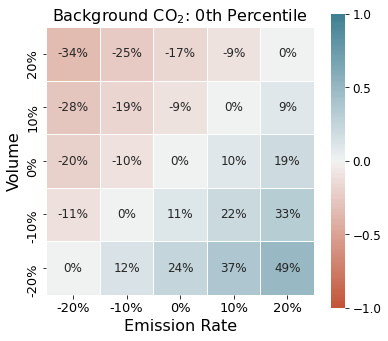

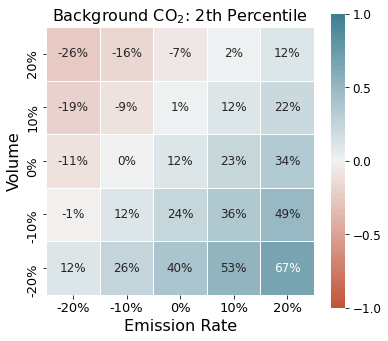

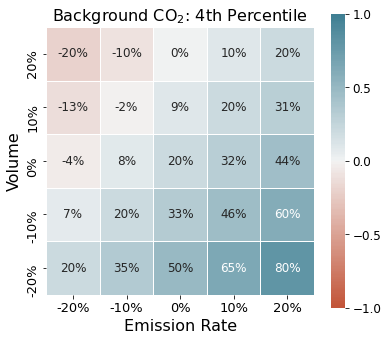

In [30]:
ss_per_inc = sa.param_range_heatmap(ss_sa_comp_per,plot=True,save=False)

In [41]:
ss_per_inc["c0_step_1"] / ss_per_inc["c0_step_0"]

e_step,-0.2,-0.1,0.0,0.1,0.2
v_step,,,,,
0.2,0.761288,0.643431,0.410652,-0.265059,inf
0.1,0.682607,0.468484,-0.154731,inf,2.521820
0.0,0.526556,-0.000000,inf,2.388800,1.741053
-0.1,0.068641,inf,2.256957,1.677825,1.489775
-0.2,inf,2.126276,1.614870,1.448316,1.365754


In [42]:
ss_per_inc["c0_step_2"] / ss_per_inc["c0_step_0"]

e_step,-0.2,-0.1,0.0,0.1,0.2
v_step,,,,,
0.2,0.598145,0.399741,-0.000000,-1.129641,inf
0.1,0.465691,0.105229,-0.943910,inf,3.561880
0.0,0.202990,-0.756662,inf,3.337949,2.247512
-0.1,-0.567879,inf,3.116000,2.141071,1.824503
-0.2,inf,2.896008,2.035091,1.754709,1.615722


### Global
Sobol Indices

Originally, I ran this function getting the SI for each estimate from each participant. This process proved to be redundant. This SA method is agnostic to the static CO2 concentration and to the participant which makes sense since we are using a wide range of parameter values. Given enough parameter values, the final answer would approach the same result regardles of the steady-state CO2 concentration. 
    
Therefore, we do _not_ need to run this method for varying steady-state CO2 nor participants.

However, the results _do_ change because the volume and emission rate parameters have a different range of values. Therefore, we should relax the limits to include the range of values and not worry about dwelling type or sex. 
    
<div>

In [ ]:
ss_first, ss_total = sa.run_sobol(method="ss")

<a id="buildup_sa"></a>

## Build-Up Estimates

### One-Way

In [ ]:
#buildup_oneway = sa.run_one_way(method="buildup",params=["c0"],steps=[0,0.25,0.75,1],verbose=True)
#buildup_oneway_summary = sa.compare_sa_to_base(buildup_oneway,estimates_decay,steps=[0,0.25,0.75,1],plot=True)
#buildup_oneway_summary

### Iterative Approach

In [31]:
#buildup_sa_comp = sa.traverse_param_range(method="buildup",steps=[0.0,0.25,0.5,0.75,1],verbose=True)
buildup_sa_comp_per = sa.traverse_param_percents(method="buildup",verbose=True)

No morning Beacon data available
Beacon 46
	Home
	Female
		C0: 0
		V: -20.0%
		E: -20.0%
	ACH: nan
		C0: 0
		V: -20.0%
		E: -10.0%
	ACH: nan
		C0: 0
		V: -20.0%
		E: 0%
	ACH: nan
		C0: 0
		V: -20.0%
		E: 10.0%
	ACH: nan
		C0: 0
		V: -20.0%
		E: 20.0%
	ACH: nan
		C0: 0
		V: -10.0%
		E: -20.0%
	ACH: nan
		C0: 0
		V: -10.0%
		E: -10.0%
	ACH: nan
		C0: 0
		V: -10.0%
		E: 0%
	ACH: nan
		C0: 0
		V: -10.0%
		E: 10.0%
	ACH: nan
		C0: 0
		V: -10.0%
		E: 20.0%
	ACH: nan
		C0: 0
		V: 0%
		E: -20.0%
	ACH: nan
		C0: 0
		V: 0%
		E: -10.0%
	ACH: nan
		C0: 0
		V: 0%
		E: 0%
	ACH: nan
		C0: 0
		V: 0%
		E: 10.0%
	ACH: nan
		C0: 0
		V: 0%
		E: 20.0%
	ACH: nan
		C0: 0
		V: 10.0%
		E: -20.0%
	ACH: nan
		C0: 0
		V: 10.0%
		E: -10.0%
	ACH: nan
		C0: 0
		V: 10.0%
		E: 0%
	ACH: nan
		C0: 0
		V: 10.0%
		E: 10.0%
	ACH: nan
		C0: 0
		V: 10.0%
		E: 20.0%
	ACH: nan
		C0: 0
		V: 20.0%
		E: -20.0%
	ACH: nan
		C0: 0
		V: 20.0%
		E: -10.0%
	ACH: nan
		C0: 0
		V: 20.0%
		E: 0%
	ACH: nan
		C0: 0
		V: 20.0%
		E: 10.0%
	AC

	ACH: nan
		C0: 4
		V: -20.0%
		E: -20.0%
	ACH: nan
		C0: 4
		V: -20.0%
		E: -10.0%
	ACH: nan
		C0: 4
		V: -20.0%
		E: 0%
	ACH: nan
		C0: 4
		V: -20.0%
		E: 10.0%
	ACH: nan
		C0: 4
		V: -20.0%
		E: 20.0%
	ACH: nan
		C0: 4
		V: -10.0%
		E: -20.0%
	ACH: nan
		C0: 4
		V: -10.0%
		E: -10.0%
	ACH: nan
		C0: 4
		V: -10.0%
		E: 0%
	ACH: nan
		C0: 4
		V: -10.0%
		E: 10.0%
	ACH: nan
		C0: 4
		V: -10.0%
		E: 20.0%
	ACH: nan
		C0: 4
		V: 0%
		E: -20.0%
	ACH: nan
		C0: 4
		V: 0%
		E: -10.0%
	ACH: nan
		C0: 4
		V: 0%
		E: 0%
	ACH: nan
		C0: 4
		V: 0%
		E: 10.0%
	ACH: nan
		C0: 4
		V: 0%
		E: 20.0%
	ACH: nan
		C0: 4
		V: 10.0%
		E: -20.0%
	ACH: nan
		C0: 4
		V: 10.0%
		E: -10.0%
	ACH: nan
		C0: 4
		V: 10.0%
		E: 0%
	ACH: nan
		C0: 4
		V: 10.0%
		E: 10.0%
	ACH: nan
		C0: 4
		V: 10.0%
		E: 20.0%
	ACH: nan
		C0: 4
		V: 20.0%
		E: -20.0%
	ACH: nan
		C0: 4
		V: 20.0%
		E: -10.0%
	ACH: nan
		C0: 4
		V: 20.0%
		E: 0%
	ACH: nan
		C0: 4
		V: 20.0%
		E: 10.0%
	ACH: nan
		C0: 4
		V: 20.0%
		E: 20.0%
	ACH: nan


In [32]:
#buildup_sa_comp.to_csv("../data/processed/sensitivity_analysis-buildup-iterative_parameter_traverse.csv",index=False)
buildup_sa_comp_per.to_csv("../data/processed/sensitivity_analysis-buildup-parameter_percent_changes.csv",index=False)

In [ ]:
buildup_sa_comp = pd.read_csv("../data/processed/sensitivity_analysis-buildup-iterative_parameter_traverse.csv",
                        parse_dates=["start","end"],infer_datetime_format=True)
buildup_sa_comp_per = pd.read_csv("../data/processed/sensitivity_analysis-buildup-parameter_percent_changes.csv",
                        parse_dates=["start","end"],infer_datetime_format=True)

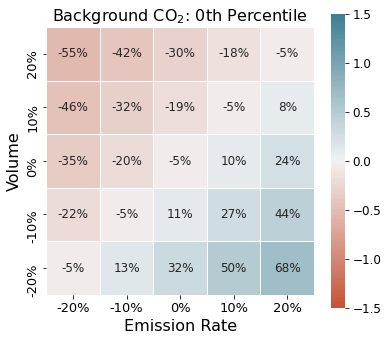

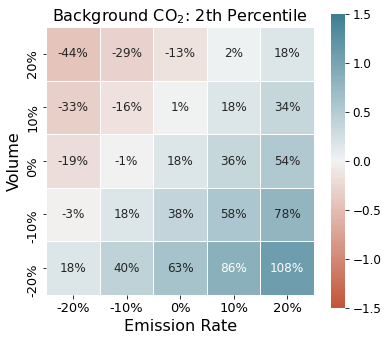

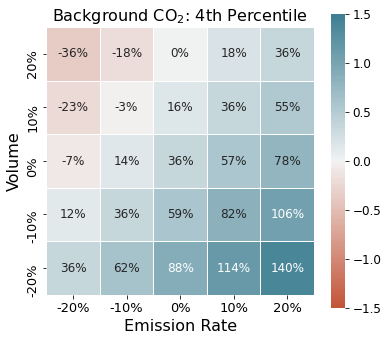

In [50]:
_ = sa.param_range_heatmap(buildup_sa_comp_per,method="buildup",plot=True,save=False,vmin=-1.5,vmax=1.5)

<a id="decay_sa"></a>

[Back to Top](#inspecting)

---